In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator

# Read the CSV files
stocks_close = pd.read_csv(r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\StockData\Googlefinance_stocks - Close_values.csv", skiprows=1)
stocks_open = pd.read_csv(r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\StockData\Googlefinance_stocks - Open_values.csv", skiprows=1)


# Clean up column names - remove empty columns
stocks_close = stocks_close.iloc[:, [0,1,3,5,7,9,11,13]]  # Select only the non-empty columns
stocks_open = stocks_open.iloc[:, [0,1,3,5,7,9,11,13]]

# Rename columns
column_names = ['Date', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'GOOGL', 'META']
stocks_close.columns = column_names
stocks_open.columns = column_names

# Convert price columns to float (replacing commas with dots)
for col in column_names[1:]:  # Skip the Date column
    stocks_close[col] = stocks_close[col].str.replace(',', '.').astype(float)
    stocks_open[col] = stocks_open[col].str.replace(',', '.').astype(float)

# First replace the time format in the date strings
stocks_close['Date'] = stocks_close['Date'].str.replace('.', ':')
stocks_open['Date'] = stocks_open['Date'].str.replace('.', ':')

# Change open dates to 9:30:00
stocks_open['Date'] = stocks_open['Date'].str[:-8] + "09:30:00"

# Convert dates to datetime
stocks_close['Date'] = pd.to_datetime(stocks_close['Date'], format='%d/%m/%Y %H:%M:%S')
stocks_open['Date'] = pd.to_datetime(stocks_open['Date'], format='%d/%m/%Y %H:%M:%S')

# Sort by date
stocks_close = stocks_close.sort_values('Date')
stocks_open = stocks_open.sort_values('Date')

# Reset indices after sorting
stocks_close.reset_index(drop=True, inplace=True)
stocks_open.reset_index(drop=True, inplace=True)

# Combine open and close data
all_stocks = pd.concat([stocks_open, stocks_close]).sort_values(by='Date').reset_index(drop=True)

In [20]:
all_stocks_long = all_stocks.melt(id_vars='Date', var_name='Stock', value_name='Price')

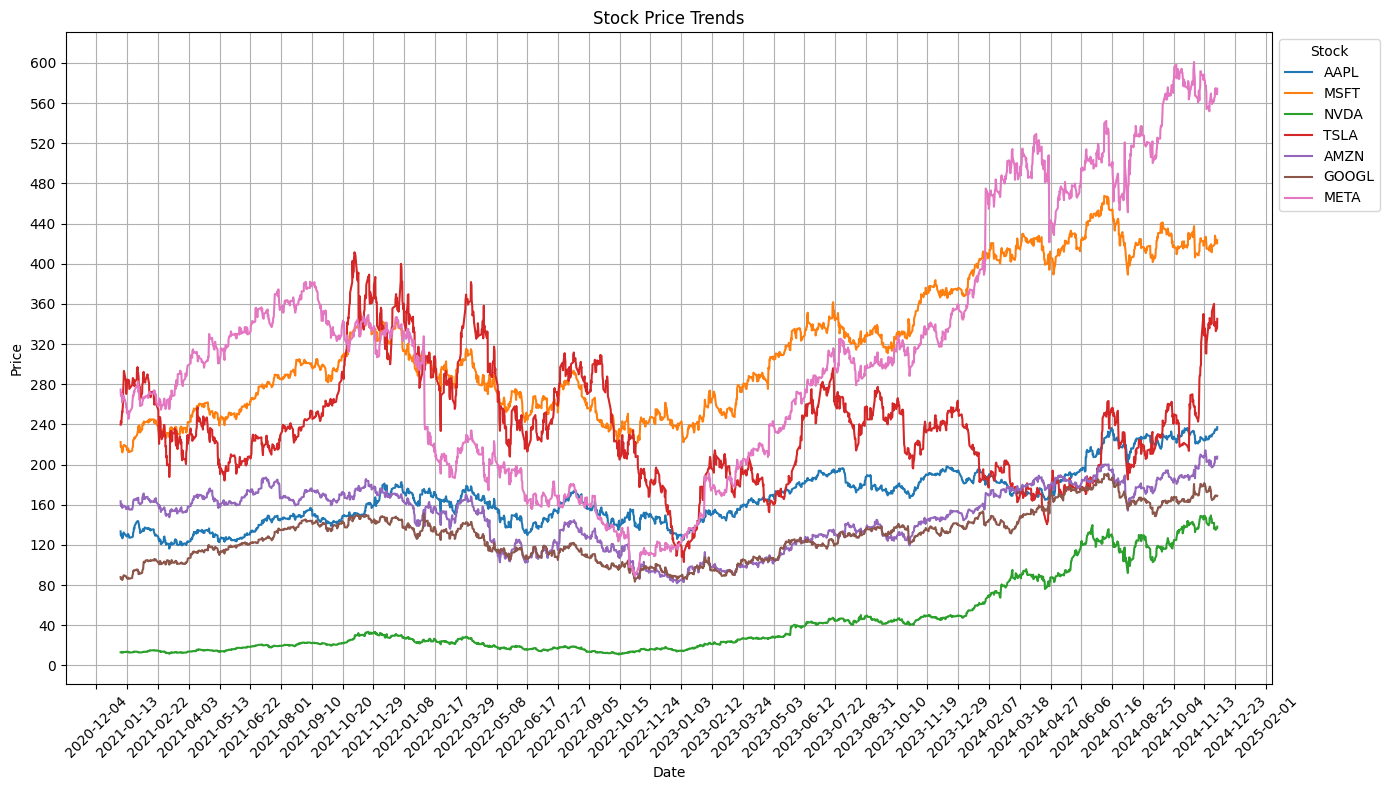

In [10]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=all_stocks_long, x='Date', y='Price', hue='Stock')
plt.title('Stock Price Trends')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid()
plt.legend(title='Stock', bbox_to_anchor=(1.00, 1), loc='upper left')
plt.xticks(rotation=45)

plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=40))  # Increase the number of x-axis ticks
plt.gca().yaxis.set_major_locator(MaxNLocator(nbins=20))  # Increase the number of y-axis ticks

plt.tight_layout()
plt.show()

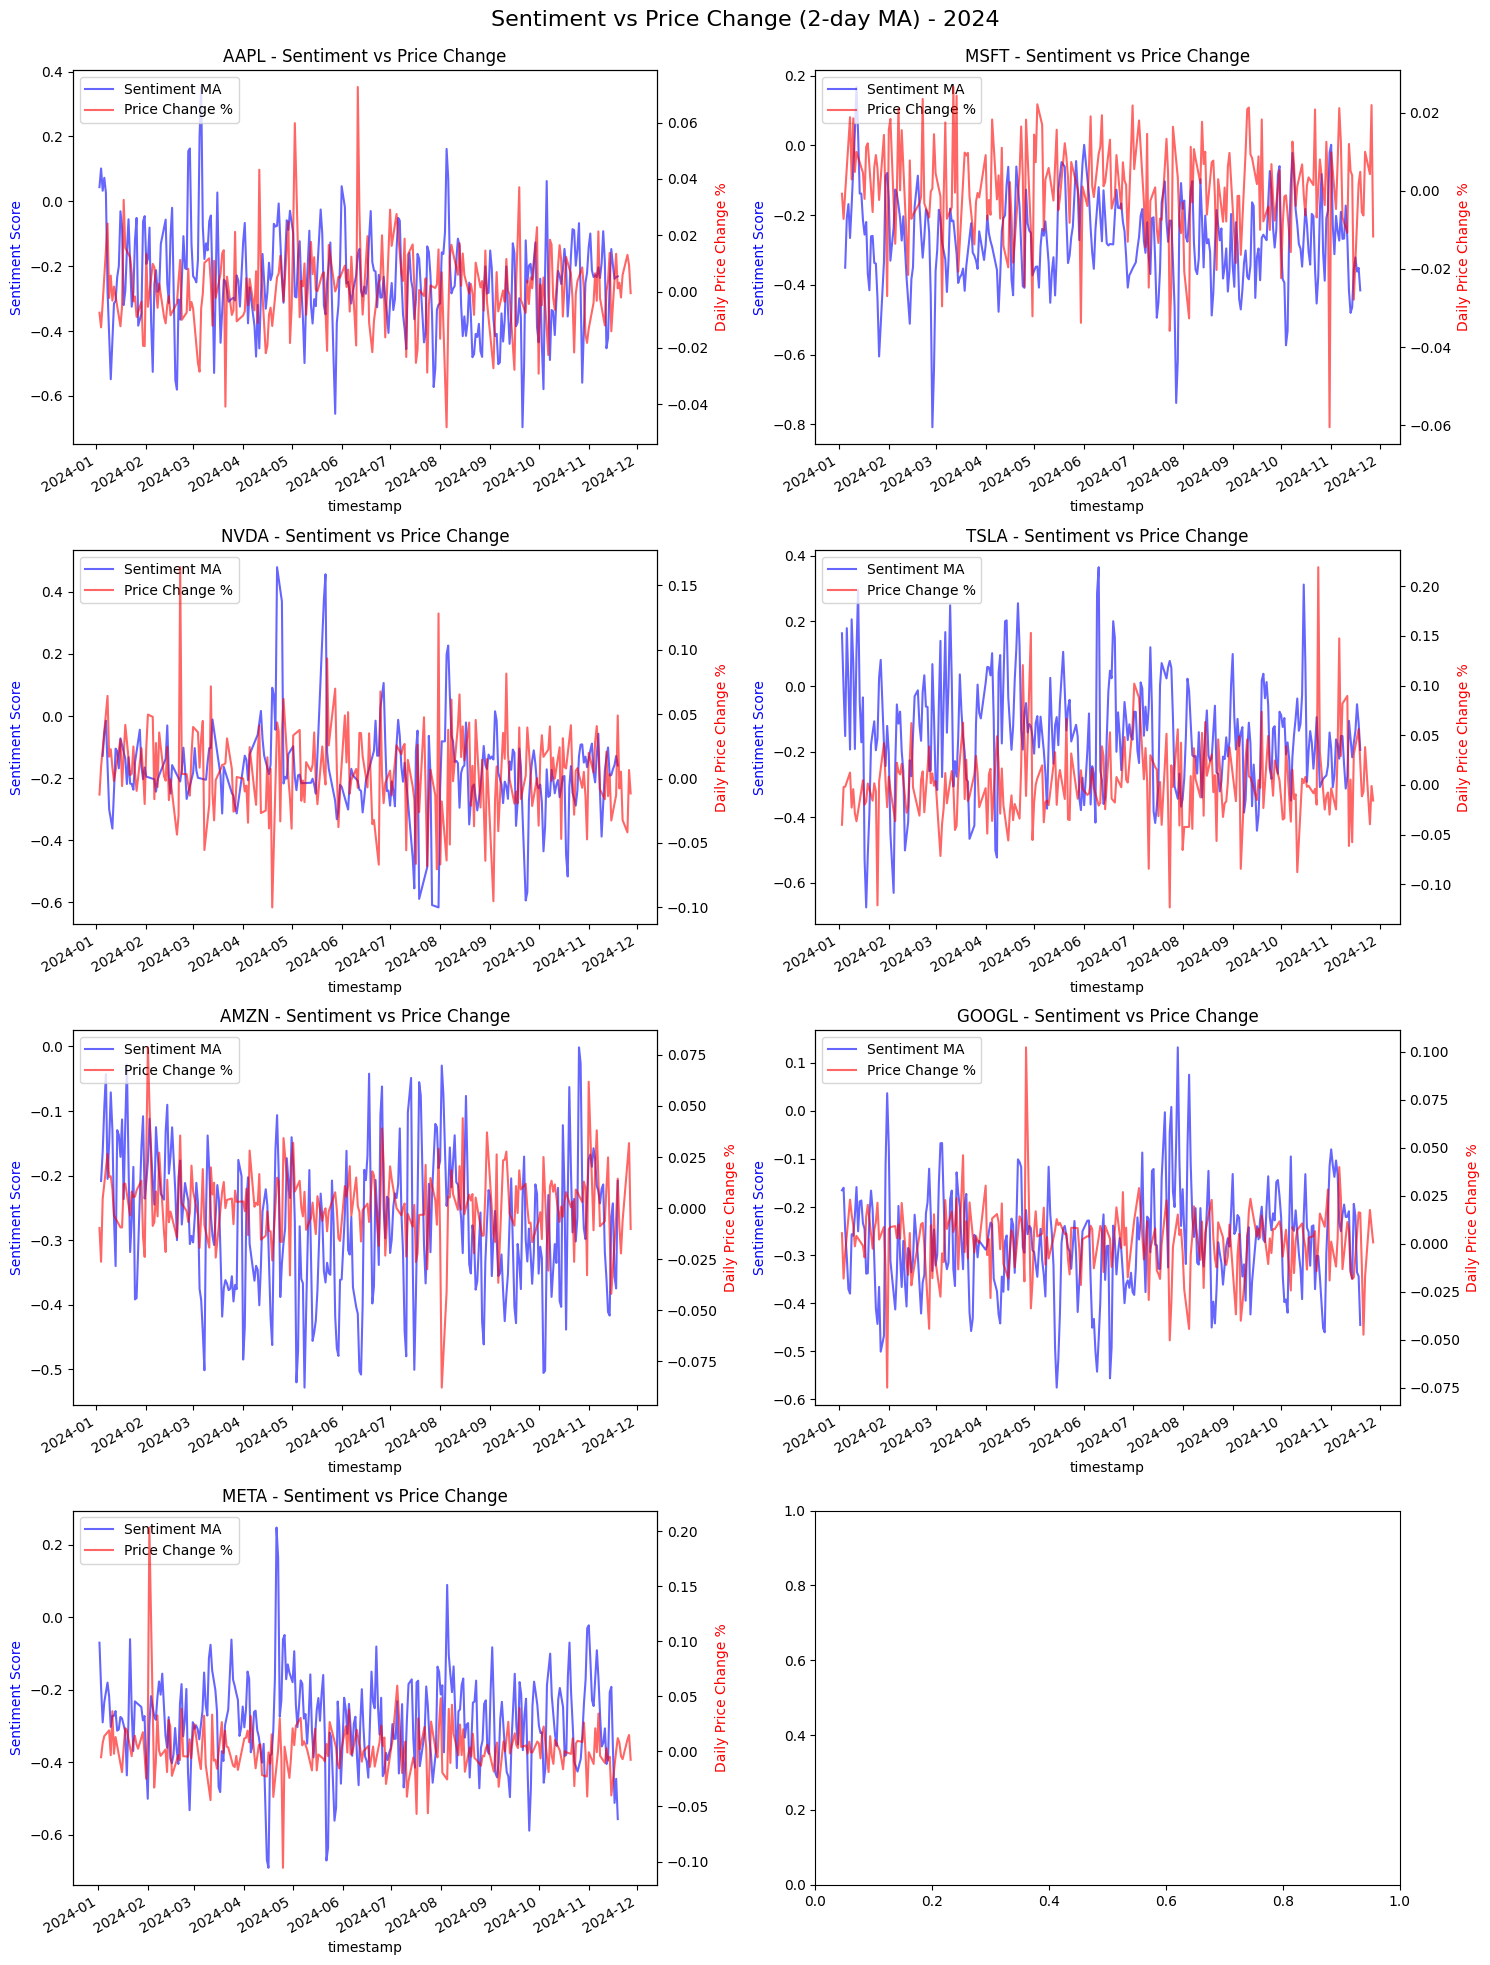


Correlations between sentiment and price changes (2024):
AAPL: -0.193
MSFT: -0.058
NVDA: -0.064
TSLA: -0.111
AMZN: 0.040
GOOGL: -0.249
META: -0.038


In [21]:
sentiment_data = pd.read_csv(r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\MarketNews\data\final\cleaned_combined_news_with_bodies_with_sentiment.csv")


# Convert timestamp to datetime and set as index
sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])

# Extract individual stocks from the list in 'stock' column
sentiment_data['stock'] = sentiment_data['stock'].apply(eval)
sentiment_expanded = sentiment_data.explode('stock')

# Filter for specific year (2024)
sentiment_expanded_2024 = sentiment_expanded[sentiment_expanded['timestamp'].dt.year == 2024]

# Calculate daily sentiment moving average (7-day window) for each stock
daily_sentiment = sentiment_expanded_2024.groupby(['stock', sentiment_expanded_2024['timestamp'].dt.date])['sentiment_score'].mean()
daily_sentiment = daily_sentiment.reset_index()
daily_sentiment['timestamp'] = pd.to_datetime(daily_sentiment['timestamp'])

# Calculate stock gradients (daily percentage change)
gradients = {}
for stock in all_stocks.columns[1:]:  # Skip the Date column
    # Filter stock data for 2024
    stock_data_2024 = all_stocks[all_stocks['Date'].dt.year == 2024]
    
    # Get end-of-day prices
    daily_prices = stock_data_2024[stock_data_2024['Date'].dt.time == pd.Timestamp('16:00:00').time()][['Date', stock]]
    daily_prices['Date'] = daily_prices['Date'].dt.date
    daily_prices.set_index('Date', inplace=True)
    
    # Calculate percentage change
    gradients[stock] = daily_prices[stock].pct_change()

# Create subplots with more space at the top
fig, axes = plt.subplots(4, 2, figsize=(15, 20))
axes = axes.flatten()

# Add main title to the figure with adjusted position
plt.subplots_adjust(top=0.95)  # Increase space at the top
fig.suptitle('Sentiment vs Price Change (2-day MA) - 2024', fontsize=16, y=0.98)

for idx, stock in enumerate(all_stocks.columns[1:]):
    ax1 = axes[idx]
    ax2 = ax1.twinx()
    
    # Get stock-specific sentiment data
    stock_sentiment = daily_sentiment[daily_sentiment['stock'] == stock].copy()
    sentiment_ma = stock_sentiment.set_index('timestamp')['sentiment_score'].rolling(window=2).mean()
    
    # Plot sentiment MA
    sentiment_ma.plot(ax=ax1, color='blue', alpha=0.6, label='Sentiment MA')
    
    # Plot stock gradient
    gradients[stock].plot(ax=ax2, color='red', alpha=0.6, label='Price Change %')
    
    ax1.set_title(f'{stock} - Sentiment vs Price Change')
    ax1.set_ylabel('Sentiment Score', color='blue')
    ax2.set_ylabel('Daily Price Change %', color='red')
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.tight_layout()
# Adjust layout after tight_layout to preserve the main title position
plt.subplots_adjust(top=0.95)  # This ensures the title doesn't overlap with subplots
# Save the current figure
plt.savefig('Figures/price_sentiment_ma.jpg', dpi=300, bbox_inches='tight')
plt.show()

# Calculate correlations for 2024
correlations = {}
for stock in all_stocks.columns[1:]:
    stock_sentiment = daily_sentiment[daily_sentiment['stock'] == stock].copy()
    sentiment_ma = stock_sentiment.set_index('timestamp')['sentiment_score'].rolling(window=2).mean()
    
    # Convert indices to datetime for proper alignment
    sentiment_idx = sentiment_ma.index.date
    gradient_idx = pd.to_datetime(gradients[stock].index)
    
    # Create aligned series
    common_dates = set(sentiment_idx).intersection(set(gradient_idx.date))
    if common_dates:
        sentiment_aligned = sentiment_ma[[d in common_dates for d in sentiment_idx]]
        gradients_aligned = gradients[stock][[d in common_dates for d in gradient_idx.date]]
        
        correlation = sentiment_aligned.corr(gradients_aligned)
        correlations[stock] = correlation

print("\nCorrelations between sentiment and price changes (2024):")
for stock, corr in correlations.items():
    print(f"{stock}: {corr:.3f}")

# Create LaTeX table for correlations
latex_table = (
    "\\begin{table}[h!]\n"
    "\\centering\n"
    "\\caption{Sentiment-Price Change Correlations (2024)}\n"
    "\\label{tab:sentiment_price_correlations}\n"
    "\\begin{tabular}{lr}\n"
    "\\hline\n"
    "Stock & Correlation \\\\\n"
    "\\hline\n"
)

# Add correlations to table
for stock, corr in correlations.items():
    latex_table += f"{stock} & {corr:.3f} \\\\\n"

latex_table += (
    "\\hline\n"
    "\\end{tabular}\n"
    "\\end{table}\n"
)

# Save LaTeX table
with open('Figures/price_sentiment_correlations.tex', 'w') as f:
    f.write(latex_table)

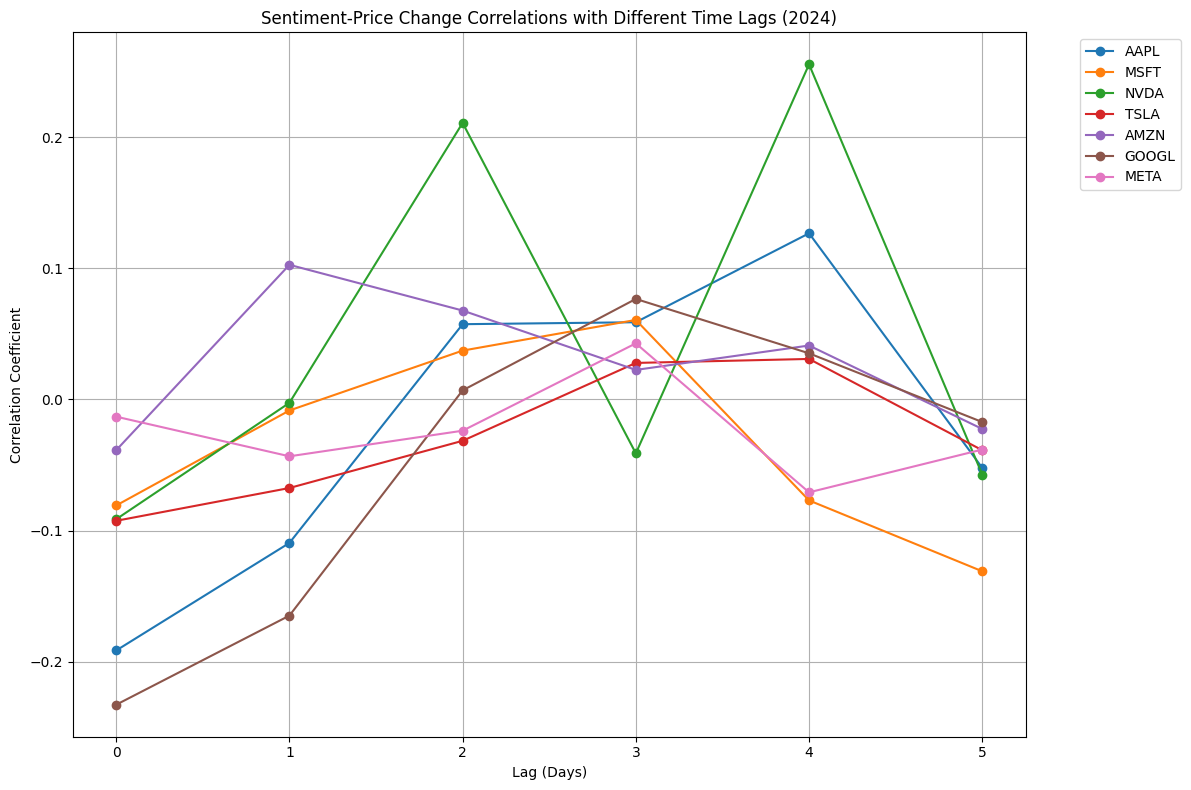


Correlations by lag days:

AAPL:
Lag 0 days: -0.191
Lag 1 days: -0.109
Lag 2 days: 0.057
Lag 3 days: 0.059
Lag 4 days: 0.127
Lag 5 days: -0.052

MSFT:
Lag 0 days: -0.081
Lag 1 days: -0.008
Lag 2 days: 0.037
Lag 3 days: 0.061
Lag 4 days: -0.077
Lag 5 days: -0.131

NVDA:
Lag 0 days: -0.091
Lag 1 days: -0.003
Lag 2 days: 0.211
Lag 3 days: -0.041
Lag 4 days: 0.255
Lag 5 days: -0.057

TSLA:
Lag 0 days: -0.093
Lag 1 days: -0.068
Lag 2 days: -0.032
Lag 3 days: 0.028
Lag 4 days: 0.031
Lag 5 days: -0.039

AMZN:
Lag 0 days: -0.039
Lag 1 days: 0.103
Lag 2 days: 0.068
Lag 3 days: 0.023
Lag 4 days: 0.041
Lag 5 days: -0.023

GOOGL:
Lag 0 days: -0.233
Lag 1 days: -0.165
Lag 2 days: 0.007
Lag 3 days: 0.077
Lag 4 days: 0.035
Lag 5 days: -0.017

META:
Lag 0 days: -0.013
Lag 1 days: -0.043
Lag 2 days: -0.024
Lag 3 days: 0.043
Lag 4 days: -0.071
Lag 5 days: -0.038

LaTeX Table:
\begin{table}[h!]
\centering
\caption{Sentiment-Price Correlations by Lag Days}
\label{tab:lag_correlations}
\begin{tabular}{lrr

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

def load_and_prepare_data():
    # Read stock data
    stocks_close = pd.read_csv("StockData/Googlefinance_stocks - Close_values.csv", skiprows=1)
    
    # Clean up column names - remove empty columns
    stocks_close = stocks_close.iloc[:, [0,1,3,5,7,9,11,13]]
    column_names = ['Date', 'AAPL', 'MSFT', 'NVDA', 'TSLA', 'AMZN', 'GOOGL', 'META']
    stocks_close.columns = column_names
    
    # Convert price columns to float
    for col in column_names[1:]:
        stocks_close[col] = stocks_close[col].str.replace(',', '.').astype(float)
    
    # Clean and convert dates
    stocks_close['Date'] = stocks_close['Date'].str.replace('.', ':')
    stocks_close['Date'] = pd.to_datetime(stocks_close['Date'], format='%d/%m/%Y %H:%M:%S')
    stocks_close = stocks_close.sort_values('Date')
    
    # Read sentiment data
    sentiment_data = pd.read_csv(r"C:\Users\jbhan\Desktop\StockMarketNewsImpact\MarketNews\data\final\cleaned_combined_news_with_bodies_with_sentiment.csv")
    sentiment_data['timestamp'] = pd.to_datetime(sentiment_data['timestamp'])
    sentiment_data['stock'] = sentiment_data['stock'].apply(eval)
    sentiment_expanded = sentiment_data.explode('stock')
    
    return stocks_close, sentiment_expanded

def calculate_lagged_correlations(stocks_close, sentiment_expanded, year=2024, max_lag_days=5):
    """Calculate correlations with different time lags"""
    
    # Filter for specific year
    stocks_year = stocks_close[stocks_close['Date'].dt.year == year]
    sentiment_year = sentiment_expanded[sentiment_expanded['timestamp'].dt.year == year]
    
    # Calculate daily price changes
    daily_returns = {}
    for stock in stocks_close.columns[1:]:
        daily_prices = stocks_year[stocks_year['Date'].dt.time == pd.Timestamp('16:00:00').time()][['Date', stock]]
        daily_prices.set_index('Date', inplace=True)
        daily_returns[stock] = daily_prices[stock].pct_change()
    
    # Calculate daily sentiment
    daily_sentiment = sentiment_year.groupby(['stock', sentiment_year['timestamp'].dt.date])['sentiment_score'].mean()
    daily_sentiment = daily_sentiment.reset_index()
    daily_sentiment['timestamp'] = pd.to_datetime(daily_sentiment['timestamp'])
    
    # Calculate correlations for different lags
    lag_correlations = {stock: [] for stock in stocks_close.columns[1:]}
    
    for lag in range(max_lag_days + 1):
        for stock in stocks_close.columns[1:]:
            stock_sentiment = daily_sentiment[daily_sentiment['stock'] == stock].copy()
            
            # Convert timestamp to date for proper alignment
            stock_sentiment['date'] = stock_sentiment['timestamp'].dt.date
            stock_sentiment = stock_sentiment.set_index('date')
            sentiment_series = stock_sentiment['sentiment_score']
            
            # Convert returns index to date
            returns_series = daily_returns[stock].copy()
            returns_series.index = pd.to_datetime(returns_series.index).date
            
            # Shift sentiment forward (to predict future returns)
            if lag > 0:
                sentiment_series = sentiment_series.shift(lag)
            
            # Align the series and calculate correlation
            aligned_data = pd.DataFrame({
                'sentiment': sentiment_series,
                'returns': returns_series
            })
            aligned_data = aligned_data.dropna()
            
            if len(aligned_data) > 0:
                correlation = aligned_data['sentiment'].corr(aligned_data['returns'])
                lag_correlations[stock].append(correlation)
            else:
                lag_correlations[stock].append(np.nan)
    
    return lag_correlations

def plot_lag_correlations(lag_correlations, max_lag_days=5):
    """Plot correlation vs lag days for each stock and generate LaTeX table"""
    plt.figure(figsize=(12, 8))
    
    for stock, correlations in lag_correlations.items():
        plt.plot(range(max_lag_days + 1), correlations, marker='o', label=stock)
    
    plt.title('Sentiment-Price Change Correlations with Different Time Lags (2024)')
    plt.xlabel('Lag (Days)')
    plt.ylabel('Correlation Coefficient')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    
    # Save high-quality plot
    plt.savefig('Figures/lag_correlations.jpg', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Generate LaTeX table
    latex_table = (
        "\\begin{table}[h!]\n"
        "\\centering\n"
        "\\caption{Sentiment-Price Correlations by Lag Days}\n"
        "\\label{tab:lag_correlations}\n"
        "\\begin{tabular}{l" + "r" * (max_lag_days + 1) + "}\n"
        "\\hline\n"
        "Stock & " + " & ".join([f"Lag {i}" for i in range(max_lag_days + 1)]) + " \\\\\n"
        "\\hline\n"
    )
    
    # Add data rows
    for stock, correlations in lag_correlations.items():
        latex_table += f"{stock} & " + " & ".join([f"{corr:.3f}" for corr in correlations]) + " \\\\\n"
    
    latex_table += (
        "\\hline\n"
        "\\end{tabular}\n"
        "\\end{table}\n"
    )
    
    # Print correlations as text and save LaTeX table
    print("\nCorrelations by lag days:")
    for stock, correlations in lag_correlations.items():
        print(f"\n{stock}:")
        for lag, corr in enumerate(correlations):
            print(f"Lag {lag} days: {corr:.3f}")
    
    # Save LaTeX table to file
    with open('Figures/lag_correlations_table.tex', 'w') as f:
        f.write(latex_table)
    
    # Print LaTeX table to console
    print("\nLaTeX Table:")
    print(latex_table)

def main():
    stocks_close, sentiment_expanded = load_and_prepare_data()
    lag_correlations = calculate_lagged_correlations(stocks_close, sentiment_expanded)
    plot_lag_correlations(lag_correlations)

if __name__ == "__main__":
    main()